In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
%run -i '../../../../utils.py'

# Read observed and predicted SCFA data

In [14]:
# read prediction error
df_model1 = pd.read_csv('./scfa_value_vs_microbiome/prediction_error_combined.csv', index_col=0)
df_model2 = pd.read_csv('./scfa_deriv_vs_microbiome/prediction_error_combined.csv', index_col=0)
df_model3 = pd.read_csv('./scfa_value_vs_constant/prediction_error_combined.csv', index_col=0)

# make absolute percent change
df_model1['AbsolutePercentError_SCFA_value'] = np.abs(df_model1['RelativeError_SCFA_value'])
df_model2['AbsolutePercentError_SCFA_value'] = np.abs(df_model2['RelativeError_SCFA_value'])
df_model3['AbsolutePercentError_SCFA_value'] = np.abs(df_model3['RelativeError_SCFA_value'])

# remove day0 of dSCFA/dt ~ microbiome model
df_model2 = df_model2[df_model2.Day != 0]

# Plot symmetric mean absolute percent error

In [3]:
all_days = set(df_model1.Day).union(set(df_model2.Day)).union(set(df_model3.Day))
lines = []
for m in [1,2,3]:
    if m==1:
        df_tmp = df_model1
    if m==2:
        df_tmp = df_model2
    if m==3:
        df_tmp = df_model3
        
    for day in all_days:
        for perturbation in ['intrapolation','extrapolation']:
            for scfa in ['Acetate','Propionate','Butyrate']:
                df_tmp2 = df_tmp[(df_tmp.Day==day)&(df_tmp.Perturbation==perturbation)&(df_tmp.SCFA_mol==scfa)]
                curr_smape = smape(df_tmp2.SCFA_value_observed, df_tmp2.SCFA_value_predicted)
                curr_r2 = r2_score(df_tmp2.SCFA_value_observed, df_tmp2.SCFA_value_predicted)
                lines.append(['model_%d'%(m), perturbation, scfa, day, curr_smape, curr_r2])
    
df_smape_r2 = pd.DataFrame(lines, columns=['Model','Perturbation','SCFA','Day','SMAPE','R2'])
df_smape_r2.head()

,Model,Perturbation,SCFA,Day,SMAPE,R2
0,model_1,intrapolation,Acetate,0,26.500398,-0.916411
1,model_1,intrapolation,Propionate,0,35.626149,-8.003187
2,model_1,intrapolation,Butyrate,0,35.694445,-6.281593
3,model_1,extrapolation,Acetate,0,26.712554,-1.372218
4,model_1,extrapolation,Propionate,0,46.648651,-22.469964


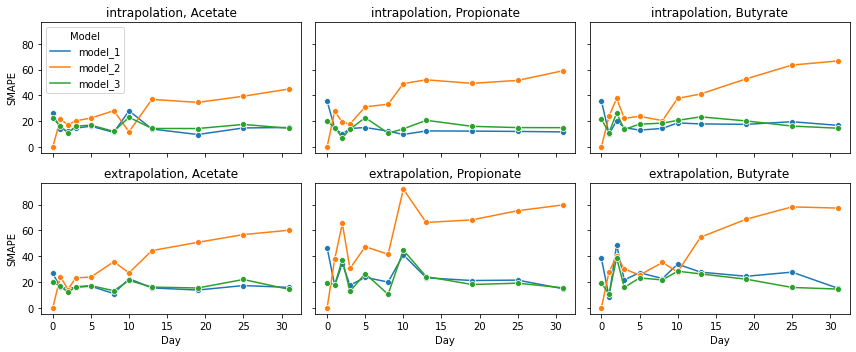

In [4]:
fig, ax = plt.subplots(figsize=(12,5), nrows=2, ncols=3, sharex=True, sharey=True)

for k1, perturbation in enumerate(['intrapolation','extrapolation']):
    for k2, scfa_ in enumerate(['Acetate','Propionate','Butyrate']):
        df_ = df_smape_r2[(df_smape_r2.Perturbation==perturbation) & (df_smape_r2.SCFA==scfa_)]
        ax[k1,k2].set_title('%s, %s'%(perturbation, scfa_))
        _ = sns.lineplot(x='Day', y='SMAPE', marker='o', data=df_, ax=ax[k1,k2], hue='Model')
        if k1!=0 or k2!=0:
            ax[k1,k2].legend().remove()
        

# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("comp_relerror_deriv_vs_conc.svg", format="svg")
plt.tight_layout()

# Plot relative error

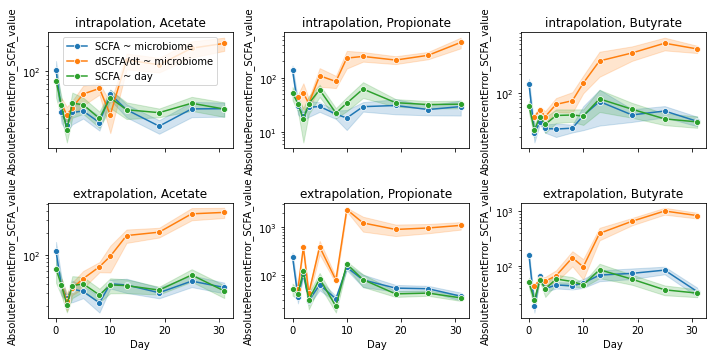

In [16]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, ncols=3, sharex=True)

for k1, perturbation in enumerate(['intrapolation','extrapolation']):
    for k2, scfa_ in enumerate(['Acetate','Propionate','Butyrate']):
        curr_df_model1 = df_model1[(df_model1.Perturbation==perturbation)&(df_model1.SCFA_mol==scfa_)]
        curr_df_model2 = df_model2[(df_model2.Perturbation==perturbation)&(df_model2.SCFA_mol==scfa_)]
        curr_df_model3 = df_model3[(df_model3.Perturbation==perturbation)&(df_model3.SCFA_mol==scfa_)]
        ax[k1,k2].set_title('%s, %s'%(perturbation, scfa_))
        _ = sns.lineplot(x='Day', y='AbsolutePercentError_SCFA_value', ci=68, marker='o', data=curr_df_model1, ax=ax[k1,k2], label='SCFA ~ microbiome')
        _ = sns.lineplot(x='Day', y='AbsolutePercentError_SCFA_value', ci=68, marker='o', data=curr_df_model2, ax=ax[k1,k2], label='dSCFA/dt ~ microbiome')
        _ = sns.lineplot(x='Day', y='AbsolutePercentError_SCFA_value', ci=68, marker='o', data=curr_df_model3, ax=ax[k1,k2], label='SCFA ~ day')
        if k1!=0 or k2!=0:
            ax[k1,k2].legend().remove()
        ax[k1,k2].set_yscale('log')

plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("model_comparison_on_daily_error.svg", format="svg")